# Description
In this notebook we show how to use pyMatchSeries in combination with Hyperspy to perform non-rigid-registration on image data as well as on spectroscopic data. The goal is to extract distortion effects from slow and fast scan noise and correct for them.

In [ ]:
import hyperspy.api as hs
import os

## 1. Import the data, download if not already on system

In [ ]:
file_path = "./data/sample_data.emd"

if not os.path.isfile(file_path):
    import wget
    print("File not found on system, downloading... please be patient")
    url = "https://owncloud.gwdg.de/index.php/s/hb7QFFl2EswRpZA/download"
    folder, filename = os.path.split(file_path)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    wget.download(url, file_path)
    print("Finished downloading file")

In [ ]:
data = hs.load(file_path, lazy=True, load_SI_image_stack=True)

## 2. Inspect the data

In [ ]:
data

In [ ]:
averaged_haadf = data[5].mean()
averaged_haadf.plot()

In [ ]:
data[7].compute()
specmap = data[7].T

In [ ]:
from skimage.filters import gaussian

specmap = specmap.rebin(scale=(8, 4, 4))
gmap = lambda x: gaussian(x, sigma=2, preserve_range=True, truncate=8)
specmap.map(gmap, inplace=True, parallel=True)
specmap = specmap.T

In [ ]:
specmap = specmap.get_lines_intensity(plot_result=True)

Before we perform the non-rigid registration, we can remove some of the noise by gaussian smoothing of the images. We can provide a pre-processing filter function when instantiating a new calculation.

In [ ]:
def smoothing(x):
    return gaussian(x, sigma=2, preserve_range=True, truncate=8)

# without smoothing
data[5].inav[0].plot()

# with smoothing
data[5].inav[0].map(smoothing, ragged=False, inplace=False).plot()

In the following cell, we figure out the starting binning level. Bin the images by factors of 2 as high as possible before the atomic columns can no longer be distinguished.

In [ ]:
data[5].inav[0].rebin(scale=(2, 2)).plot() # startLevel = stoplevel -1
data[5].inav[0].rebin(scale=(4, 4)).plot() # startLevel = stoplevel -2
data[5].inav[0].rebin(scale=(8, 8)).plot() # startLevel = stoplevel -3

Startlevel 2 below the stop level should be good

## 3. Set up non-rigid registration calculation

In [ ]:
from pymatchseries import MatchSeries

First we create a new MatchSeries object, providing the file path and a pre-processing function. You may also apply a number of options from the config file as keyword arguments. We change the config file a few cells down.

Instead of a file path to a .hspy or .emd file, you should also be able to supply a hs.signals.Signal2D or 3D numpy array

In [ ]:
calculation = MatchSeries.new(file_path, image_filter = smoothing)

In [ ]:
calculation.summary

You can see that in this dataset there are two image series. We will work from the HAADF image series (index=5). We can edit the configuration file before running the calculation as follows:

In [ ]:
configuration = {
    "templateNumOffset": 0,
    "templateNumStep": 1,
    "templateSkipNums": [100, 101, 103],
}
calculation.modify_configuration(configuration, 5)

You can check out all the configuration settings like this:

In [ ]:
cf = calculation.load_configuration(5)
print(cf)

## 4. Running the calculation
Once we are happy with the configuration, we run the calculation as follows (warning, this can take a few hours):

In [ ]:
calculation.calculate_deformations(5)

Once the calculation is done, the results have been stored and are persistent. You may close an reopen a calculation to check this.

In [ ]:
calculation.close()

In [ ]:
calculation = MatchSeries.load("sample_data")

In [ ]:
calculation.summary

## 5. Visualizing and applying the results
The result of the calculation are X-Y deformation fields for each image in the respective image stack. These can be loaded in as a complex array (X+iY), which can be visualized in a number of ways. The power spectrum:

In [ ]:
defs = calculation.load_deformations_as_signal2D(5)

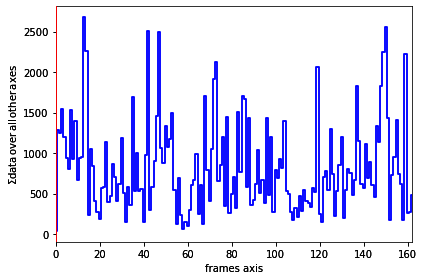

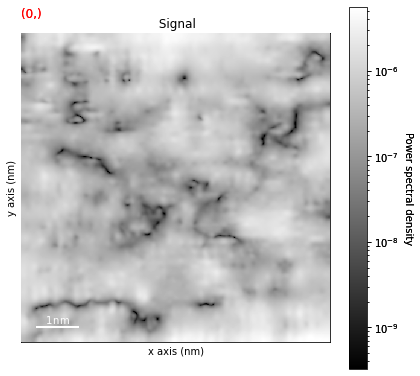

In [5]:
defs.plot(power_spectrum=True)

Or the angle. One might also think to plot a vector field using various methods in the matplotlib toolbox.

In [10]:
angle = defs.angle()

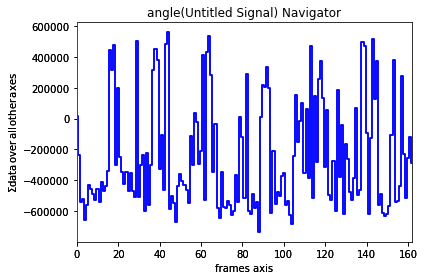

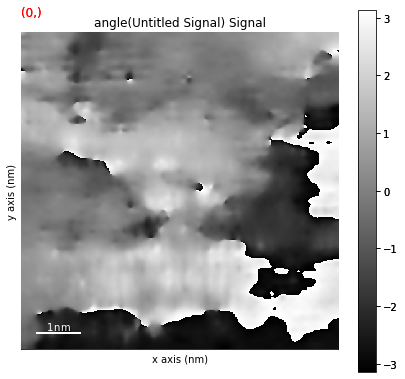

In [12]:
angle.plot()

We can save out the deformations to a convenient format:

In [ ]:
defs.save("data/deformations_haadf.hspy")

To apply the calculated deformations to the images, we load the data again. Because we want to apply the deformations to the individual spectrum frames as well, we must make sure to not load the summed spectrum.

In [ ]:
data = hs.load(file_path, sum_frames=False, lazy=True, load_SI_image_stack=True)

In [ ]:
images_deformed = calculation.apply_deformations_to_images(data[5], index=5)

In [ ]:
images_deformed.save("data/deformed_haadf.hspy")

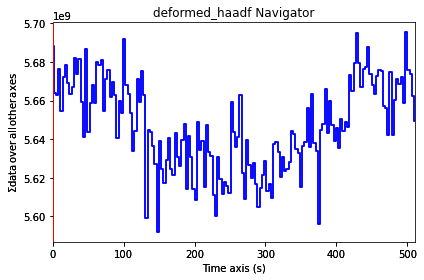

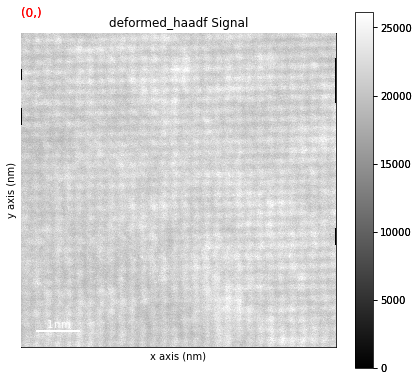

In [10]:
images_deformed.plot()

In [ ]:
corrected_spectrum = calculation.apply_deformations_to_spectra(data[-1], index=5)

In [ ]:
corrected_spectrum

In [ ]:
corrected_spectrum.save("data/corrected_spectrum.hspy")